In [ ]:
!pip install transformers
!pip install sacremoses

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -q scanpy
!pip install -q leidenalg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 83.8 MB/s eta 0:00:00


In [ ]:
!pip uninstall numba
!pip install -q umap-learn==0.5.1
!pip install -U numba
#!pip install -e git+https://github.com/lmcinnes/umap.git@0.4dev#egg=umap4
#!pip install /content/src/umap4

Found existing installation: numba 0.57.0
Uninstalling numba-0.57.0:
  Would remove:
    /usr/local/bin/numba
    /usr/local/lib/python3.10/dist-packages/numba-0.57.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/numba/*
Proceed (Y/n)? y
  Successfully uninstalled numba-0.57.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import torch
from transformers import HerbertTokenizer, RobertaModel, AutoTokenizer, BertModel

import umap
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
def get_data_set(labels, df):
  idxs = []
  for label in labels:
    idxs_for_label, = np.where(df['Label'] == label)
    for idx in idxs_for_label:
      idxs.append(idx)

  new_df = df.iloc[idxs]
  new_df = new_df.sample(frac = 1).reset_index(drop=True)
  return new_df

In [ ]:
def print_classes(df):
  y = df["Label"]
  #jeśli jest mniej niż 8 klas:
  if len(df['Label'].unique()) < 8:
    y = df ['Label'].factorize()[0]
  authors = {}
  num_classes = len(df['Label'].unique())
  for label in range(0, num_classes):
    i, = np.where(y == label)
    authors['{}'.format(df['Author-short'][i[0]])] = label

  return authors

In [ ]:
def make_tokens(df, model):
  model_name, tokenizer, model = model
  tokens = {}

  df_tokens = pd.DataFrame()
  tokenize = lambda sent: tokenizer.encode_plus(sent, max_length=512, padding='max_length', truncation=True)
  df_tokens['tokens'] = df['Text'].map(tokenize)
  df_tokens['input_ids'] = df_tokens['tokens'].map(lambda t: t['input_ids'] )
  df_tokens['token_type_ids'] = df_tokens['tokens'].map(lambda t: t['token_type_ids'] )
  df_tokens['attention_mask'] = df_tokens['tokens'].map(lambda t: t['attention_mask'] )


  input_ids = np.stack(df_tokens['input_ids'])
  token_type_ids = np.stack(df_tokens['token_type_ids'])
  attention_mask = np.stack(df_tokens['attention_mask'])

  inputs = {"input_ids":torch.tensor(input_ids),"token_type_ids":torch.tensor(token_type_ids),"attention_mask":torch.tensor(attention_mask)}

  return df_tokens, inputs


In [ ]:
df_tokens, inputs = make_tokens(df_raw, herbert)

In [ ]:
outputs = model(**inputs)

In [ ]:
#dzielenie tokenów na 9 porcji
X_stack = []
embedded = {}
model_name, tokenizer, model = herbert

for idx in tqdm(range(0,400)):
  x = 0

  for i in range(0,9):

    y = x+100
    if(i>7):
      y = 512

    input_ids = np.stack(df_tokens["input_ids"].iloc[idx:idx+1])
    token_type_ids = np.stack(df_tokens["token_type_ids"].iloc[idx:idx+1])
    attention_mask = np.stack(df_tokens["attention_mask"].loc[idx:idx+1])

    input_ids = np.array([input_ids[0][x:y]])
    token_type_ids = np.array([token_type_ids[0][x:y]])
    attention_mask = np.array([attention_mask[0][x:y]])

    x = x + 60

    inputs = {"input_ids":torch.tensor(input_ids),"token_type_ids":torch.tensor(token_type_ids),"attention_mask":torch.tensor(attention_mask)}

    single_poem_output = model(**inputs)
    X_single_poem = single_poem_output[0][:,0,:].detach().numpy()
    X_stack.append(X_single_poem[0])
    embedded[idx,i] = X_single_poem[0], df_raw['Label'][idx]


  df_embedded = pd.DataFrame.from_dict(embedded,  orient='index', columns=['embedding', 'label'])



In [ ]:
def make_embedding(df, model):

  X_stack = []
  model_name, tokenizer, model = model
  embedded = {}
  tokens = {}
  num_idxs = df.shape[0]
  for idx in tqdm(range(0,num_idxs)):
    single_poem_input = df['Text'][idx]
    inputs = tokenizer.batch_encode_plus([single_poem_input], max_length = 512, padding="longest", add_special_tokens=True, return_tensors="pt",)
    single_poem_output = model(**inputs)
    X_single_poem = single_poem_output[0][:,0,:].detach().numpy()
    X_stack.append(X_single_poem[0])

    embedded[idx] = X_single_poem[0], df['Label'][idx]

  df_embedded = pd.DataFrame.from_dict(embedded,  orient='index', columns=['embedding', 'label'])

  return df_embedded

In [ ]:
def get_X_y(df):

  X = np.stack(df['embedding'])
  y = df['Label']

  #jeśli jest mniej niż 8 klas:
  if len(df['Label'].unique()) < 8:
    y = df ['Label'].factorize()[0]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

  print(X.shape)

  return X, y, X_train, X_test, y_train, y_test,  X_val, y_val

In [ ]:
def normalize_data(X):

  X_normalized = np.zeros((X.shape[0],X.shape[1]))

  for idx in range(0,X.shape[0]):
    X_normalized[idx,:] = (X[idx,:] - np.mean(X[idx,:]))/ np.std(X[idx,:])

  return X_normalized

In [ ]:
herbert_large = ["Herbert-large", HerbertTokenizer.from_pretrained("allegro/herbert-large-cased"), RobertaModel.from_pretrained("allegro/herbert-large-cased")]
herbert_base = ["Herbert-base", HerbertTokenizer.from_pretrained("allegro/herbert-base-cased"), RobertaModel.from_pretrained("allegro/herbert-base-cased")]
herbert_klej = ["Herbert-klej", HerbertTokenizer.from_pretrained("allegro/herbert-klej-cased-tokenizer-v1"), RobertaModel.from_pretrained("allegro/herbert-klej-cased-v1")]

You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at allegro/herbert-large-cased were not used when initializing RobertaModel: ['bert.encoder.layer.12.attention.output.dense.weight', 'bert.encoder.layer.18.attention.self.query.bias', 'bert.encoder.layer.6.attention.self.query.weight', 'bert.encoder.layer.19.attention.output.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'bert.encoder.layer.17.attention.output.LayerNorm.bias', 'bert.encoder.layer.18.attention.self.key.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.self.value.weight', 'bert.encoder.layer.17.attention.self.key.bias', 'bert.encoder.layer.22.attention.output.dense.bias', 'bert.encoder.layer.0.output.dense.weight', 'bert.encoder.layer.8.attention.self.key.weight', 'bert.encoder.layer.20.attention.output.dense.bias', 'bert.encoder.layer.0.i

You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.


Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing RobertaModel: ['bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.11.attention.self.query.bias', 'bert.encoder.layer.6.attention.self.query.weight', 'bert.encoder.layer.9.attention.self.value.weight', 'bert.encoder.layer.2.output.dense.bias', 'bert.encoder.layer.7.attention.self.value.weight', 'bert.encoder.layer.7.attention.output.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'bert.encoder.layer.7.attention.self.query.weight', 'bert.encoder.layer.11.intermediate.dense.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.self.value.weight', 'bert.encoder.layer.6.intermediate.dense.weight', 'bert.encoder.layer.7.attention.self.key.bias', 'bert.encoder.layer.4.attention.self.key.bias', 'bert.encoder.layer.0.output.dense.weight', 'bert.encoder.layer.8.attention.self.key.weight', 'bert.encoder.layer.11.output.LayerNorm.bias', 'bert

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLMTokenizer'. 
The class this function is called from is 'HerbertTokenizer'.


In [ ]:
df_raw = pd.read_csv('/content/wiersze_do_BERT_Herbert_Miłosz.csv', ";")
df_raw .columns

/tmp/ipykernel_22171/895382405.py:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  df_raw = pd.read_csv('/content/wiersze_do_BERT_Herbert_Miłosz.csv', ";")


Index(['Author', 'Author-short', 'Title', 'Text', 'From', 'Note', 'Words',
       'Label', 'Gender', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11'],
      dtype='object')

In [ ]:
df_raw  = df_raw .drop(columns = ['Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11'])
df_raw.shape

(450, 9)

In [ ]:
df_raw = df_raw.drop(df_raw.index[400:])
df_raw

,Author,Author-short,Title,Text,From,Note,Words,Label,Gender
0,Jan Kochanowksi,J. Kochanowki,Pieśń III,"Nie wierz Fortunie, co siedzisz wysoko; Miej n...",Księgi wróte,NaN,147.0,0.0,0.0
1,Jan Kochanowksi,J. Kochanowki,Pieśń IV,W twardej kamiennej wieży i za troistemi Drzwi...,Księgi wróte,NaN,250.0,0.0,0.0
2,Jan Kochanowksi,J. Kochanowki,Pieśń V,"Wieczna sromota i nienagrodzona Szkoda, Polaku...",Księgi wróte,NaN,250.0,0.0,0.0
3,Jan Kochanowksi,J. Kochanowki,Pieśń VI,"Królewno lutnie złotej i rymów pociesznych, Oc...",Księgi wróte,NaN,109.0,0.0,0.0
4,Jan Kochanowksi,J. Kochanowki,Pieśń IX,"Nie porzucaj nadzieje, Jakoć sie kolwiek dziej...",Księgi wróte,NaN,143.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
395,Ewa Lipska,E. Lipska,Wielki Odkrywco Wyobraźni,Wielki Odkrywco Wyobraźni na rybiookich wspart...,NaN,NaN,106.0,7.0,1.0
396,Ewa Lipska,E. Lipska,Wyznanie mężczyzny od którego kobieta odchodzi...,Odchodzisz ode mnie jak lato. I powracasz do m...,NaN,NaN,109.0,7.0,1.0
397,Ewa Lipska,E. Lipska,Z listu (II),I jak tu popełnić samobójstwo droga pani kiedy...,NaN,NaN,63.0,7.0,1.0
398,Ewa Lipska,E. Lipska,Wolny przekład z Szekspira,W oczy mi patrzysz wciąż tak samo jak w tysiąc...,NaN,NaN,143.0,7.0,1.0


In [ ]:
df_orginal = pd.DataFrame
df_orginal = pd.concat([df_raw['Text'],df_raw['Label'],df_raw['Author-short']], axis=1)

In [ ]:
df_orginal

,Text,Label,Author-short
0,"Nie wierz Fortunie, co siedzisz wysoko; Miej n...",0.0,J. Kochanowki
1,W twardej kamiennej wieży i za troistemi Drzwi...,0.0,J. Kochanowki
2,"Wieczna sromota i nienagrodzona Szkoda, Polaku...",0.0,J. Kochanowki
3,"Królewno lutnie złotej i rymów pociesznych, Oc...",0.0,J. Kochanowki
4,"Nie porzucaj nadzieje, Jakoć sie kolwiek dziej...",0.0,J. Kochanowki
...,...,...,...
395,Wielki Odkrywco Wyobraźni na rybiookich wspart...,7.0,E. Lipska
396,Odchodzisz ode mnie jak lato. I powracasz do m...,7.0,E. Lipska
397,I jak tu popełnić samobójstwo droga pani kiedy...,7.0,E. Lipska
398,W oczy mi patrzysz wciąż tak samo jak w tysiąc...,7.0,E. Lipska


In [ ]:
df_women = df_raw[200:].reset_index(drop=True)
df_men = df_raw[:200].reset_index(drop=True)
#df_women = df_women.sample(frac = 1).reset_index(drop=True)
#df_men = df_men.sample(frac = 1).reset_index(drop=True)

In [ ]:
embedding_men = make_embedding(df_men, herbert_klej)
df_men = pd.concat([df_men, embedding_men['embedding']], axis=1)
df_men

100%|██████████| 200/200 [00:18<00:00, 11.11it/s]


,Author,Author-short,Title,Text,From,Note,Words,Label,Gender,embedding
0,Jan Kochanowksi,J. Kochanowki,Pieśń III,"Nie wierz Fortunie, co siedzisz wysoko; Miej n...",Księgi wróte,NaN,147.0,0.0,0.0,"[0.9823111, 0.17659464, -0.13114046, 0.2979802..."
1,Jan Kochanowksi,J. Kochanowki,Pieśń IV,W twardej kamiennej wieży i za troistemi Drzwi...,Księgi wróte,NaN,250.0,0.0,0.0,"[1.3060236, -0.39340982, -0.38579014, 0.345086..."
2,Jan Kochanowksi,J. Kochanowki,Pieśń V,"Wieczna sromota i nienagrodzona Szkoda, Polaku...",Księgi wróte,NaN,250.0,0.0,0.0,"[1.4037676, -0.08101153, -0.7218148, 0.6507863..."
3,Jan Kochanowksi,J. Kochanowki,Pieśń VI,"Królewno lutnie złotej i rymów pociesznych, Oc...",Księgi wróte,NaN,109.0,0.0,0.0,"[0.8545519, 0.19631115, -0.7711401, 0.4401112,..."
4,Jan Kochanowksi,J. Kochanowki,Pieśń IX,"Nie porzucaj nadzieje, Jakoć sie kolwiek dziej...",Księgi wróte,NaN,143.0,0.0,0.0,"[0.8898635, -0.23231414, -0.18887755, 0.257005..."
...,...,...,...,...,...,...,...,...,...,...
195,Zbigniew Herbert,Z. Herbert,Czerwona chmura,Czerwona chmura pyłu wołała tamten pożar – zac...,Struna światła,NaN,90.0,3.0,0.0,"[-0.7386654, -0.95941514, -0.20553033, 0.35537..."
196,Zbigniew Herbert,Z. Herbert,Napis,Patrzysz na moje ręce są słabe – mówisz – jak ...,Struna światła,NaN,87.0,3.0,0.0,"[-0.12620744, -0.12171071, -0.09506205, 0.8267..."
197,Zbigniew Herbert,Z. Herbert,Trzy wiersze z pamięci,I Nie mogę trafić na tytuł wspomnienia o Tobie...,Struna światła,NaN,242.0,3.0,0.0,"[-0.43426326, -0.3900616, -0.7660448, 1.173496..."
198,Zbigniew Herbert,Z. Herbert,Poległym poetom,Śpiewak ma wargi zestalone śpiewak wymawia noc...,Struna światła,NaN,93.0,3.0,0.0,"[-0.27473626, -0.13656917, -0.60429907, 0.5733..."


In [ ]:
embedding_women = make_embedding(df_women, herbert_klej)
df_women = pd.concat([df_women, embedding_women['embedding']], axis=1)
df_women

100%|██████████| 200/200 [00:14<00:00, 13.69it/s]


,Author,Author-short,Title,Text,From,Note,Words,Label,Gender,embedding
0,Wisława Szymborska,W. Szymborska,Niewinność,Poczęta na materacu z ludzkich włosów. Gerda. ...,NaN,NaN,137.0,4.0,1.0,"[0.29479247, -0.12235016, 0.055246387, 0.62251..."
1,Wisława Szymborska,W. Szymborska,Kot w pustym mieszkaniu,Umrzeć - tego nie robi się kotu. Bo co ma pocz...,NaN,NaN,159.0,4.0,1.0,"[-0.4353818, -0.52265936, 0.16930553, 0.525711..."
2,Wisława Szymborska,W. Szymborska,Kobiety Rubensa,"Waligórzanki, żeńska fauna, jak łoskot beczek ...",NaN,NaN,145.0,4.0,1.0,"[-0.04652969, -0.042072475, -0.57108986, 0.522..."
3,Wisława Szymborska,W. Szymborska,Jawność,"Oto my, nadzy kochankowie, piękni dla siebie –...",NaN,NaN,144.0,4.0,1.0,"[0.21233146, 0.08834981, -0.3515874, 0.7700373..."
4,Wisława Szymborska,W. Szymborska,Jacyś ludzie,Jacyś ludzie w ucieczce przed jakimiś ludźmi. ...,NaN,NaN,149.0,4.0,1.0,"[-0.25606328, -0.21348338, 0.43639264, 0.35540..."
...,...,...,...,...,...,...,...,...,...,...
195,Ewa Lipska,E. Lipska,Wielki Odkrywco Wyobraźni,Wielki Odkrywco Wyobraźni na rybiookich wspart...,NaN,NaN,106.0,7.0,1.0,"[-0.095793076, -0.13406874, -0.49464127, 0.695..."
196,Ewa Lipska,E. Lipska,Wyznanie mężczyzny od którego kobieta odchodzi...,Odchodzisz ode mnie jak lato. I powracasz do m...,NaN,NaN,109.0,7.0,1.0,"[-0.08856931, -0.4127864, 0.112047136, 1.34274..."
197,Ewa Lipska,E. Lipska,Z listu (II),I jak tu popełnić samobójstwo droga pani kiedy...,NaN,NaN,63.0,7.0,1.0,"[0.414671, -0.26945838, 0.21376199, 0.4289035,..."
198,Ewa Lipska,E. Lipska,Wolny przekład z Szekspira,W oczy mi patrzysz wciąż tak samo jak w tysiąc...,NaN,NaN,143.0,7.0,1.0,"[-0.053692695, 0.045533076, -0.30511746, 0.772..."


In [ ]:
classes = print_classes(df_women)
classes

{'W. Szymborska': 0,
 'H. Poświatowska': 1,
 'M. P. Jasnorzewska': 2,
 'E. Lipska': 3}

In [ ]:
X, y, _,_,_,_,_,_ = get_X_y(df_women)

(200, 768)


In [ ]:
X_norm = normalize_data(X)

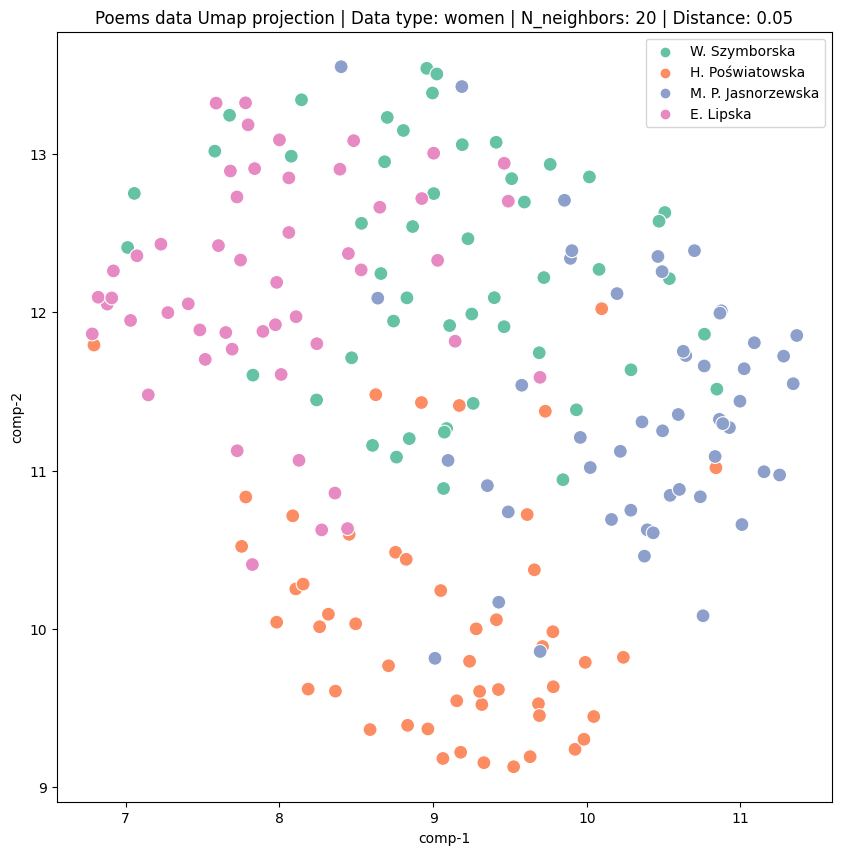

In [ ]:
# Umap
df_umap = pd.DataFrame()
df_umap["y"] = df_women['Author-short']
data_type = 'women'
num_classes = len(classes)
n_neighbors = [20]
min_distnces= [0.05]
n_components=2
metric='euclidean'

for n_neighbor in n_neighbors:
  for min_dist in min_distnces:
    reducer = umap.UMAP(n_neighbors=n_neighbor,
            min_dist=min_dist,
            n_components=n_components,
            metric=metric)
    scaled_X = StandardScaler().fit_transform(X)
    embed = reducer.fit_transform(scaled_X)

    df_umap["comp-1"] = embed[:,0]
    df_umap["comp-2"] = embed[:,1]

    plt.figure(figsize = (10,10))
    sns.scatterplot(x="comp-1", y="comp-2", hue=df_umap.y.tolist(),
                   palette=sns.color_palette("Set2", num_classes),
                   data=df_umap, s=100).set(title="Poems data Umap projection | Data type: {} | N_neighbors: {} | Distance: {}".format(data_type, n_neighbor, min_dist))


plt.savefig('/content/figs/umap_{}.png'.format(data_type))
#files.download('/content/figs/umap_{}.png'.format(data_type))

In [ ]:
# 3D Umap
data_type = 'women'
num_classes = len(classes)
n_neighbors = [20]
min_distnces= [0.05]
n_components=3
metric='euclidean'
for n_neighbor in n_neighbors:
  for min_dist in min_distnces:
    reducer = umap.UMAP(n_neighbors=n_neighbor,
                min_dist=min_dist,
                n_components=n_components,
                metric=metric)
    scaled_X = StandardScaler().fit_transform(X)
    embed = reducer.fit_transform(scaled_X)

    Xax = embed[:,0]
    Yax = embed[:,1]
    Zax = embed[:, 2]



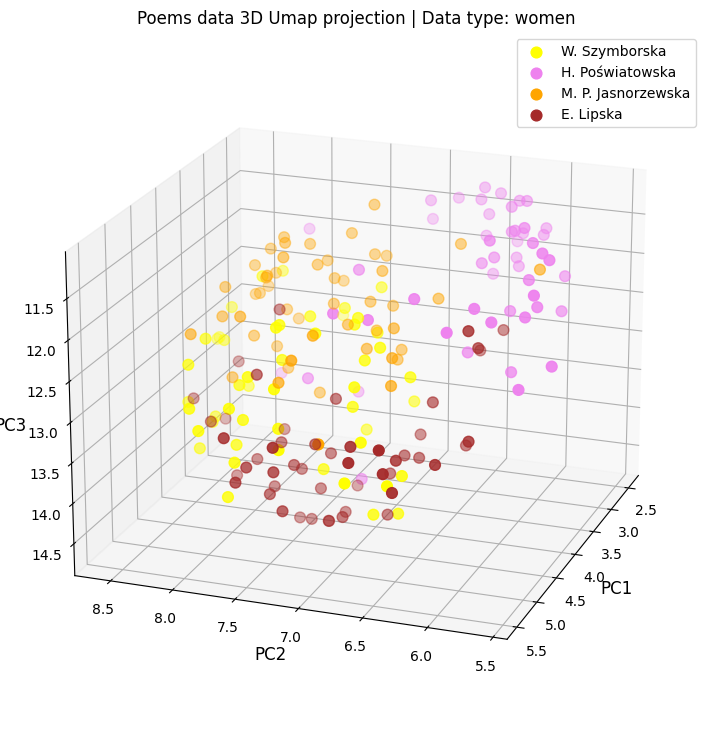

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#cdict = {0:'cyan',1:'red',2:'blue',3:'green',4:'yellow',5:'violet',6:'orange',7:'brown'}
cdict = {0:'yellow',1:'violet',2:'orange',3:'brown'}
#label = {0:'J. Kochanowki',1:'K. K. Baczyński',2:'Cz. Miłosz',3:'Z. Herbert'}
label = {0:'W. Szymborska',1:'H. Poświatowska',2:'M. P. Jasnorzewska',3:'E. Lipska'}

fig = plt.figure(figsize=(14,9))
ax = fig.add_subplot(111,
                    projection='3d')

for l in np.unique(y):
  ix=np.where(y==l)
  ax.scatter(Xax[ix],
              Yax[ix],
              Zax[ix],
              c=cdict[l],
              s=60,
            label=label[l])

ax.set_xlabel("PC1",
              fontsize=12)
ax.set_ylabel("PC2",
              fontsize=12)
ax.set_zlabel("PC3",
              fontsize=12)

ax.view_init(200, 160)
ax.legend()
plt.title("Poems data 3D Umap projection | Data type: {}".format(data_type))
plt.show()

fig.savefig('/content/figs/umap_3D_{}.png'.format(data_type))
files.download('/content/figs/umap_3D_{}.png'.format(data_type))

In [ ]:
# 3D PCA
data_type = 'women'
scaler = StandardScaler()
scaler.fit(X)
scaled_X = scaler.transform(X)
pca = PCA(n_components=3)
pca.fit(scaled_X)
pca_X = pca.transform(scaled_X)

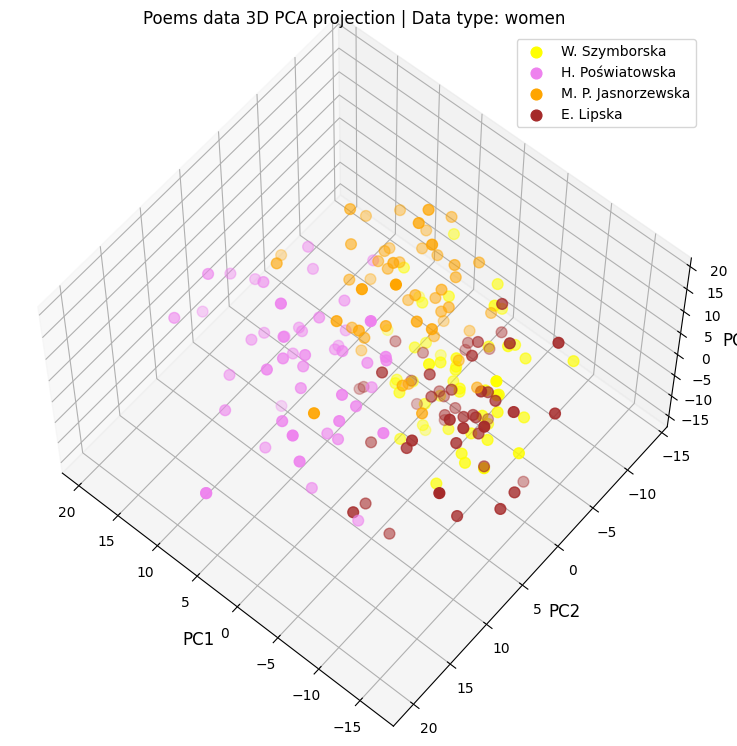

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
angle1 = 5

angles = [290]# np.arange(100,175,5)
for angle2 in angles:
  Xax = pca_X[:,0]
  Yax = pca_X[:,1]
  Zax = pca_X[:,2]

  #cdict = {0:'cyan',1:'red',2:'blue',3:'green',4:'yellow',5:'violet',6:'orange',7:'brown'}
  cdict = {0:'yellow',1:'violet',2:'orange',3:'brown'}
  #label = {0:'J. Kochanowki',1:'K. K. Baczyński',2:'Cz. Miłosz',3:'Z. Herbert'}
  label = {0:'W. Szymborska',1:'H. Poświatowska',2:'M. P. Jasnorzewska',3:'E. Lipska'}

  fig = plt.figure(figsize=(14,9))
  ax = fig.add_subplot(111,
                     projection='3d')

  for l in np.unique(y):
    ix=np.where(y==l)
    ax.scatter(Xax[ix],
              Yax[ix],
              Zax[ix],
              c=cdict[l],
              s=60,
            label=label[l])

  ax.set_xlabel("PC1",
                fontsize=12)
  ax.set_ylabel("PC2",
                fontsize=12)
  ax.set_zlabel("PC3",
                fontsize=12)

  ax.view_init(60, 130)
  ax.legend()
  plt.title("Poems data 3D PCA projection | Data type: {} ".format(data_type))
  plt.show()

fig.savefig('/content/figs/pca_3D_{}.png'.format(data_type))
files.download('/content/figs/pca_3D_{}.png'.format(data_type))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

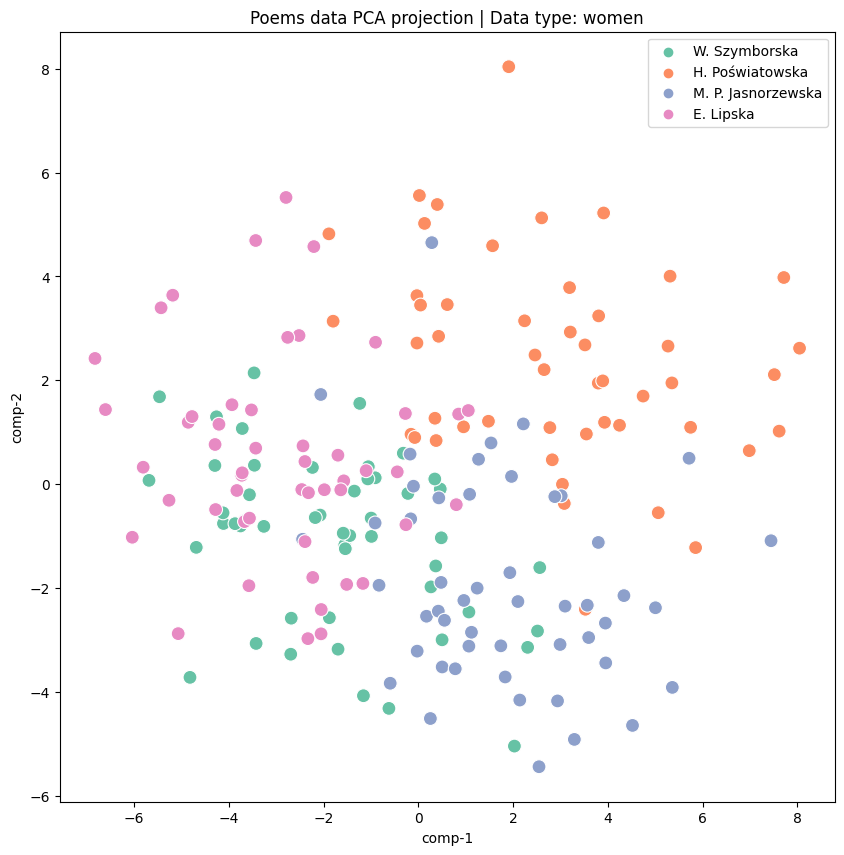

In [ ]:
df_pca = pd.DataFrame()
df_pca["y"] = df_women['Author-short']
data_type = 'women'
num_classes = len(classes)

plt.figure(figsize = (10,10))
pca = PCA(n_components=2).fit_transform(X, y)

df_pca["comp-1"] = pca[:,0]
df_pca["comp-2"] = pca[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df_pca.y.tolist(),
                palette=sns.color_palette("Set2", num_classes),
                data=df_pca, s=100).set(title="Poems data PCA projection | Data type: {}".format(data_type))

plt.savefig('/content/figs/pca_{}.png'.format(data_type))
files.download('/content/figs/pca_{}.png'.format(data_type))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

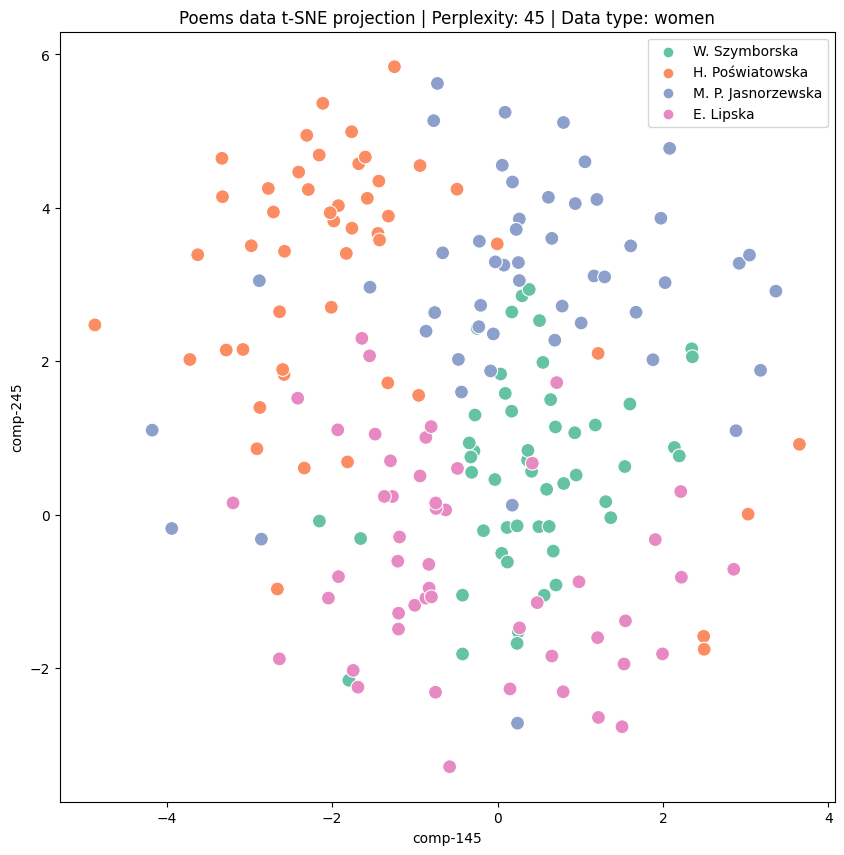

In [ ]:
df_tsne = pd.DataFrame()
df_tsne["y"] = df_women['Author-short']
data_type = 'women'
num_classes = len(classes)

perps = [45]

for perp in perps:

  plt.figure(figsize = (10,10))
  z = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=perp).fit_transform(X, y)

  df_tsne["comp-1{}".format(perp)] = z[:,0]
  df_tsne["comp-2{}".format(perp)] = z[:,1]

  sns.scatterplot(x="comp-1{}".format(perp), y="comp-2{}".format(perp), hue=df_tsne.y.tolist(),
                palette=sns.color_palette("Set2", num_classes),
                data=df_tsne, s=100).set(title="Poems data t-SNE projection | Perplexity: {} | Data type: {}".format(perp, data_type))

  plt.savefig('/content/figs/tsne_{}_{}_perplexity.png'.format(data_type, perp))
  files.download('/content/figs/tsne_{}_{}_perplexity.png'.format(data_type, perp))

In [ ]:
distance_euclidean_X_normalized = np.zeros((X_norm.shape[0], X_norm.shape[0]))
distance_cosinus_X_normalized = np.zeros((X_norm.shape[0], X_norm.shape[0]))

for i in range(0,distance_euclidean_X_normalized.shape[0]):
  x_normalized_i = X_norm[i,:]
  for j in range(0,distance_euclidean_X_normalized.shape[0]):
    x_normalized_j = X_norm[j,:]
    distance_euclidean_X_normalized[i,j] = np.sqrt(np.sum( np.abs(x_normalized_i - x_normalized_j)**2))
    distance_cosinus_X_normalized[i,j] = np.dot(x_normalized_i, x_normalized_j)/1024


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

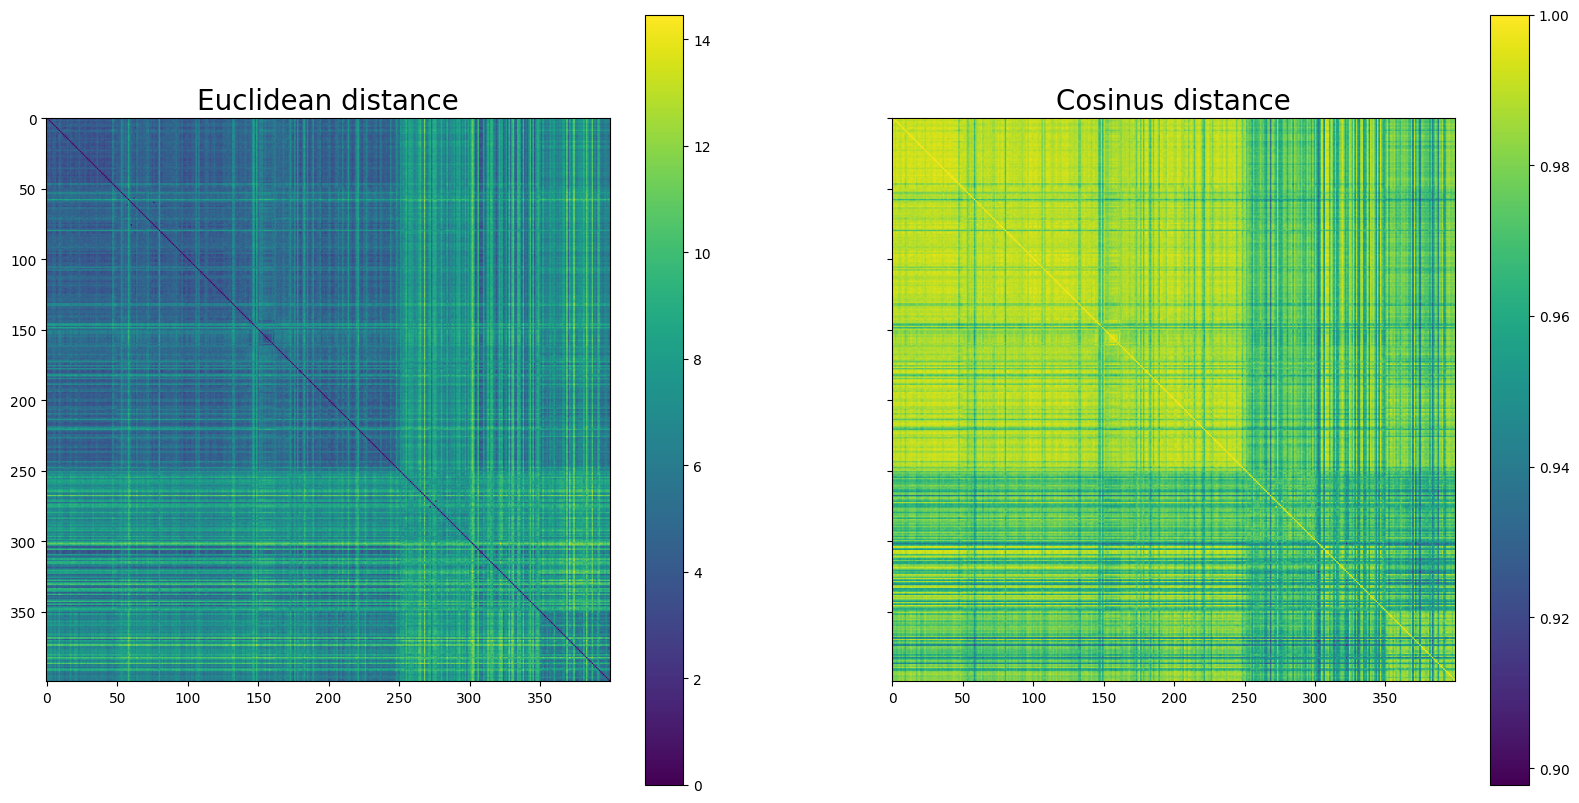

In [ ]:
distances = {"Euclidean distance":distance_euclidean_X_normalized, "Cosinus distance":distance_cosinus_X_normalized}
data_type = "all"
fig, ax = plt.subplots(1,2, figsize=(20,10), sharey='row')
im = ax[0].imshow(distance_euclidean_X_normalized)
ax[0].set_title('Euclidean distance', fontsize=20)
im2 = ax[1].imshow(distance_cosinus_X_normalized)
ax[1].set_title('Cosinus distance', fontsize=20)
fig.colorbar(im, ax=ax[0])
fig.colorbar(im2, ax=ax[1])

fig.savefig('/content/figs/euclidean_and_cosinus.png')
files.download('/content/figs/euclidean_and_cosinus.png')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

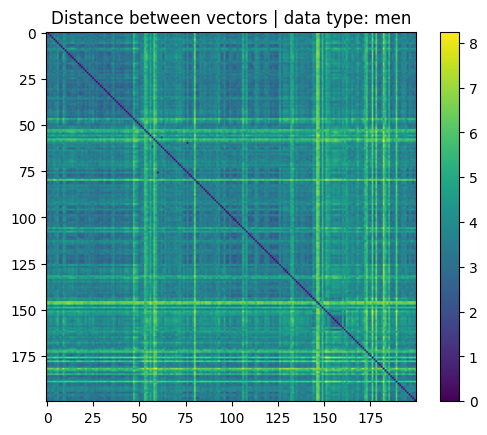

In [ ]:
M_men = np.zeros((200,200))

for i in range(0,200):
  x_i = embedded_men['Herbert_embedding'][i]
  for j in range(0,200):
    x_j = embedded_men['Herbert_embedding'][j]

    #scalar_product = np.dot(x_i, x_j)
    #M[i,j] = scalar_product
    M_men[i,j] = np.sqrt(np.sum( np.abs(x_i - x_j)**2))
plt.imshow(M_men)
plt.colorbar()
plt.title('Distance between vectors | data type: men')


plt.savefig('/content/odległość_wektorów_po_ombeddingu_men.png')
files.download('/content/odległość_wektorów_po_ombeddingu_men.png')